# The Thomson problem
 $ \textit{by Mark Jeremy G. Narag | PhD Physics student | 2014-64423}$

Imagine having two balls in a giant hallow sphere. If we want the two balls to be equidistant, we will place them across each other. For 3 balls, we can perhaps draw an equilateral triangle inside the sphere and put the balls on each corner of this equilateral triangle. For 4, a tetrahedron. For 5, a triangular pyramid and so on. So what if we have 100 balls? 200? This is the Thompson problem proposed by physicist Joseph John Thomson in 1904. Let's say the balls are electrons constrained to the surface of a unit sphere. The goal of the Thomson problem is to find the arrangement of $N$ electrons that will result in the lowest electrostatic potential energy. 

#### The Physics of it
Remember that in Coulumb's Law, the energy $U$ occurring between each pair of electrons of equal charges is given by
$$ {\displaystyle U_{ij}(N)={k q_{i}q_{j} \over r_{ij}}} $$
where $k = 4 \pi\epsilon_0$ and $r_{ij}=|\mathbf {r} _{i}-\mathbf {r} _{j}|$, which is the distance between the two particles.

We can simplify it by making $q=1$ and $k=1$ without lossing the generality of our problem,
$$ {\displaystyle U_{ij}(N)={1 \over r_{ij}}} $$
So for the total electrostatic potential energy of N-electrons, we can express it as the sum of all pair-wise interaction,
$${\displaystyle U_{ij}(N)=\sum {\frac {1}{r_{ij}}}}$$
The above equation $U_{ij}(N)$ will be minimized over all possible configurations of N distinct electrons.

#### The simulation of it

There are actually many minimization algorithms available in python. In this activity, we will create two (2) different algorithms that can solve our Thomson problem. Specifically,

[✓] Method 1: Euler method 

[✓] Method 2: Gradient descent - I normally use this when training a machine learning model where I minimize the loss function every epoch. Let's try it here!



We can start by randomly distributing the charged particles on the surface of a sphere. We will then calculate the forces (inversely proportional to the square of the distance instead of energy) between the particles and let them evolve through time. After every time step, we will normalize the particle's distance so that they remain on the sphere. We can also add a damping force proportional to the particle speed which will be very convenient so that the system eventually stops. 

-------------------------------------------------------------------------------------------------------------------

## Let's code!

First, we create a function `random_initial` that initializes the particle positions randomly on the surface of a unit sphere. It takes `n_particles` as an input and returns the initial cartesian coordinates `coordinates_init` generated. 

In [1]:
import numpy as np

def random_initial(n_particles):
    coordinates_init = np.random.normal(size=(n_particles, 3))
    #np.linalg.norm is used to calculate the norm of our vector so the particles will be bounded in unit sphere
    coordinates_init /= np.linalg.norm(coordinates_init, axis=1)[:, np.newaxis]
    return coordinates_init

Next, let's create another function `force` that calculates the pair-wise forces between the particles. In takes the cartesian coordinates as input and returns the total force (in x, y, z) experience by each particle.

Note that force is given by $${\displaystyle F_{ij}(N)=\sum {\frac {kq_i q_j}{|\mathbf {r} _{i}-\mathbf {r} _{j}|^3}} (\mathbf {r}_{i} - \mathbf {r}_{j})}$$ 
In our code, we let `r` to be $(\mathbf {r}_{i} - \mathbf {r}_{j})$ and `R` to be $|\mathbf {r} _{i}-\mathbf {r} _{j}|$ where `R` is the magnitude of the Euclidean distance of the two vectors.

Additionally, I created an energy function `energy` so we can check later if the energy is really decreasing every iteration. Notice that the return is U/2 because $U_{ij}$ = $U_{ji}$. There's actually a scipy package in python called `pdist` that automatically computes for the sum of pairwise distances in n-dimensional space. I wrote it the function `calculate_potential` incase we want to try.

In [2]:
def force(coordinates):
    N = int(np.size(coordinates)/3)
    F = np.zeros([N,3]) 
    for i in range(N):
        f_sum = 0 
        for j in range(N):
            if i != j: 
                r = coordinates[i] - coordinates[j]
                R = np.sqrt(sum(r**2)) #Eucledian distance
                f = r/(R**3) #force of two particles
                f_sum = f_sum + f #add it to the previous force to get the total sum
        F[i] = f_sum #this will now be the total force experienced by particle i
    return F

def energy(coordinates):
    N = int(np.size(coordinates)/3)
    U = 0
    for i in range(N):
        U_sum = 0 
        for j in range(N):
            if i != j: 
                r = coordinates[i] - coordinates[j]
                R = np.sqrt(sum(r**2)) #Eucledian distance
                U += 1/R
    return U/2

from scipy.spatial.distance import pdist, squareform
def calculate_potential(coordinates):
    distances = pdist(coordinates)
    return np.sum(1 / distances)

Let's check if the two functions we wrote will give almost the same output - one is from scratch, one is a package, respectively.

In [3]:
x = random_initial(5)
print(energy(x))
print(calculate_potential(x))

9.782090015474441
9.782090015474441


Now we are ready to create different methods that can minimize $F_{ij}(N)$. Let's start with Euler method.

## Method 1: Euler

Let's say we are given a 1D ODE:
$$\frac{du}{dt} = f(u,t)$$
Euler approximation works by considering a finite time step $\Delta t$ such that:
$$\Delta u \approx f\Delta t$$
for every $\Delta t$, $u$ gets updated
$$u \leftarrow u+\Delta u$$

We will use this concept in updating our positions `x` `y` `z` and velocities  `vx` `vy` `vz`. Let's define a function `euler` which takes three input arguments - `int_coor` (random initial coordinate), `n_iterations` (number of iterations), `dt` (step size), then gives two outputs - `coordinates` (final coordinate) and `energies` (energy per iteration).

In the function below, we first created empty arrays where we will store our positions `x` `y` `z` and velocities  `vx` `vy` `vz`  in which we will update every iteration. We set an arbitrary initial velocity of 0.5.

Next, for each of the particle `j`, we will update its velocity $\mathbf{v'}$ and position $\mathbf{p'}$ using Euler's concept where


$$\mathbf{v} \leftarrow \mathbf{v} + \mathbf{F}\Delta t$$
$$\mathbf{p} \leftarrow \mathbf{p} + \mathbf{v}\Delta t$$

Don't forget to normalize the positions so it will still stay on the unit sphere.


In [4]:
def euler(int_coor,n_iterations,dt):
    N = int(np.size(int_coor)/3)

    #Let's create empty arrays first
    arrays = ['x', 'y', 'z','vx','vy','vz']
    for name in arrays:
        globals()[name] = np.zeros([1001,N]) 

    coordinates = int_coor
    x[0] = coordinates[:,0]
    y[0] = coordinates[:,1]
    z[0] = coordinates[:,2] 
    v0 = 0.5 #arbitrary
    vx[0] = v0
    vy[0] = v0
    vz[0] = v0 
    
    energies = []
    
    for _ in range(n_iterations):
        energies.append(energy(coordinates))
        for j in range(N):
            F = force(coordinates) 
            vx[j+1] = vx[j] + (F[:,0])*dt
            vy[j+1] = vy[j] + (F[:,1])*dt
            vz[j+1] = vz[j] + (F[:,2])*dt
            x[j+1] = x[j] + vx[j]*dt
            y[j+1] = y[j] + vy[j]*dt
            z[j+1] = z[j] + vz[j]*dt
            coordinates[:,0] = x[j+1] 
            coordinates[:,1] = y[j+1]
            coordinates[:,2] = z[j+1]
            coordinates /= np.linalg.norm(coordinates, axis=1)[:, np.newaxis] #normalize
        
    return coordinates, energies

Let's visualize what happens every iteration

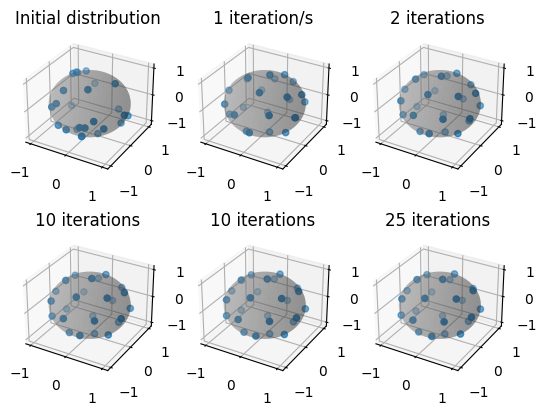

Text(0, 0.5, 'Energy, U')

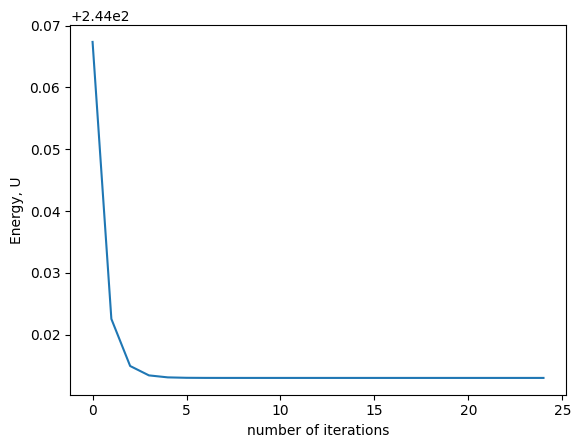

In [5]:
import matplotlib.pyplot as plt


N = 25 # particle number
initial_coordinate = random_initial(N)


fig = plt.figure()
ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax6 = fig.add_subplot(236, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(x, y, z, color='gray', alpha=0.3)
ax2.plot_surface(x, y, z, color='gray', alpha=0.3)
ax3.plot_surface(x, y, z, color='gray', alpha=0.3)
ax4.plot_surface(x, y, z, color='gray', alpha=0.3)
ax5.plot_surface(x, y, z, color='gray', alpha=0.3)
ax6.plot_surface(x, y, z, color='gray', alpha=0.3)

ax1.scatter(initial_coordinate[:,0],initial_coordinate[:,1],initial_coordinate[:,2])
ax1.set_title('Initial distribution')

iteration = [1,2,10,10,25]
dt = 0.1

final = euler(initial_coordinate,iteration[0],dt)[0]
ax2.scatter(final[:,0],final[:,1],final[:,2])
ax2.set_title(str(iteration[0])+' iteration/s')

final = euler(initial_coordinate,iteration[1],dt)[0]
ax3.scatter(final[:,0],final[:,1],final[:,2])
ax3.set_title(str(iteration[1])+' iterations')

final = euler(initial_coordinate,iteration[2],dt)[0]
ax4.scatter(final[:,0],final[:,1],final[:,2])
ax4.set_title(str(iteration[2])+' iterations')

final = euler(initial_coordinate,iteration[3],dt)[0]
ax5.scatter(final[:,0],final[:,1],final[:,2])
ax5.set_title(str(iteration[3])+' iterations')

#let's get the energy for the largest iteration
final_ = euler(initial_coordinate,iteration[4],dt)
final = final_[0]
energies = final_[1]
ax6.scatter(final[:,0],final[:,1],final[:,2])
ax6.set_title(str(iteration[4])+' iterations')

plt.show()

plt.figure()
plt.plot(energies)
plt.xlabel('number of iterations')
plt.ylabel('Energy, U')



As we can see, we don't actually need to iterate it that long. $U_{ij}(N)$ was already (optimally) minimized at 5 iterations at least.

Now, let's try higher number of particles. Say 250

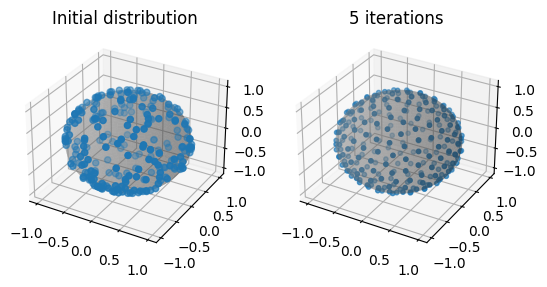

Text(0, 0.5, 'Energy, U')

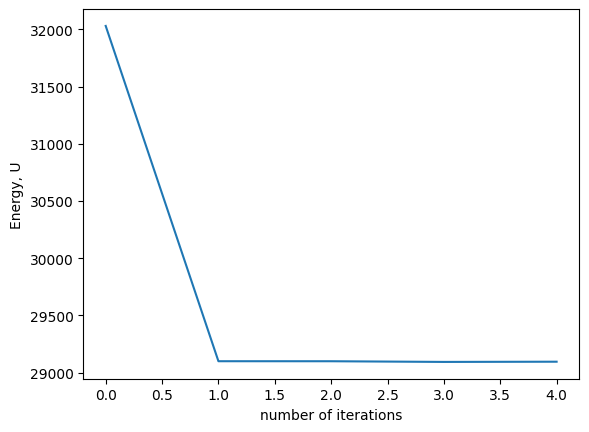

In [6]:
import matplotlib.pyplot as plt


N = 250 # particle number
initial_coordinate = random_initial(N)


fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(x, y, z, color='gray', alpha=0.3)
ax2.plot_surface(x, y, z, color='gray', alpha=0.3)

ax1.scatter(initial_coordinate[:,0],initial_coordinate[:,1],initial_coordinate[:,2])
ax1.set_title('Initial distribution')

energies = []

#let's get the energy for the largest iteration
final_ = euler(initial_coordinate,5,0.1)
final = final_[0]
energies = final_[1]
ax2.scatter(final[:,0],final[:,1],final[:,2], s=10)
ax2.set_title('5 iterations')

plt.show()

plt.figure()
plt.plot(energies)
plt.xlabel('number of iterations')
plt.ylabel('Energy, U')

## Method 2: Gradient descent

Gradient descent is actually used popularly in machine learning where we also find the minimum of a function, which is the loss function. It works by adjusting the parameters of a model iteratively. This is in contrast to Euler where at each time step, it approximates the derivative of the function and updates the solution based on this approximation. In gradient descent, it updates the parameters in the opposite direction of the gradient of the loss function with respect to the parameters.

Mathematically,
$$u_{t+1} \leftarrow u_{t} - \alpha \Delta J(u_{t})$$

where $u_{t}$ represents the parameters at iteration $t$, $\alpha$ is the learning rate which determines the step size in each iteration, and $\Delta J(u_{t})$ is the gradient of the loss function $J$ with respect to the parameters $u_{t}$. As you can see, it is minus, not plus. In the code, $\alpha$ is dt.


In [7]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def gradient_descent(int_coor,n_iterations,dt):
    coordinates = int_coor
    energies = []

    # Perform energy minimization using gradient descent
    for _ in range(n_iterations):
        energies.append(energy(coordinates))
        distances = squareform(pdist(coordinates))
        inv_distances = 1 / distances
        np.fill_diagonal(inv_distances, 0)

        gradients = np.sum((inv_distances - np.diag(np.sum(inv_distances, axis=1)))[:, :, np.newaxis] * coordinates, axis=1)
        coordinates -= dt * gradients

        # Renormalize coordinates to keep particles on the surface of the sphere
        coordinates /= np.linalg.norm(coordinates, axis=1)[:, np.newaxis]

    return coordinates, energies

/var/folders/jy/04tql0zn0r5gxkthn6r5ss4h0000gn/T/ipykernel_34064/2363854110.py:15: RuntimeWarning: divide by zero encountered in divide
  inv_distances = 1 / distances


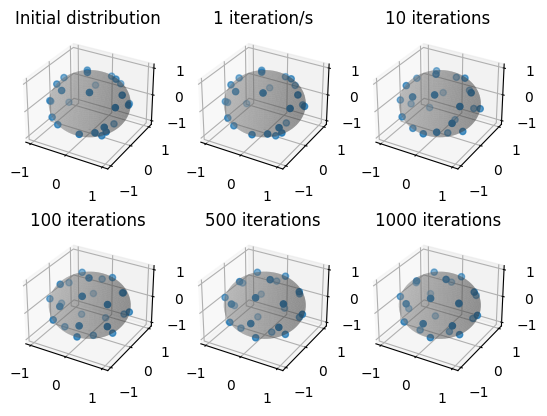

Text(0, 0.5, 'Energy, U')

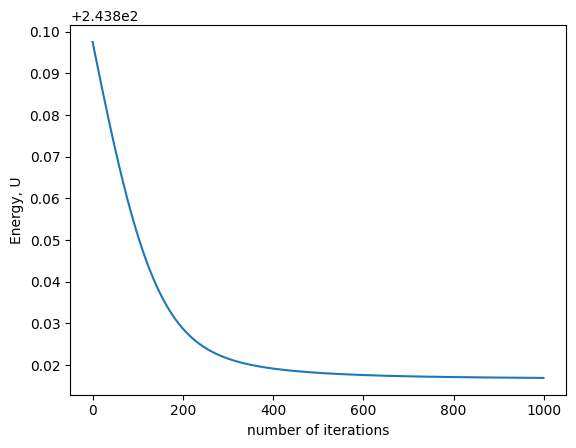

In [11]:
import matplotlib.pyplot as plt


N = 25 # particle number
initial_coordinate = random_initial(N)


fig = plt.figure()
ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax6 = fig.add_subplot(236, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(x, y, z, color='gray', alpha=0.3)
ax2.plot_surface(x, y, z, color='gray', alpha=0.3)
ax3.plot_surface(x, y, z, color='gray', alpha=0.3)
ax4.plot_surface(x, y, z, color='gray', alpha=0.3)
ax5.plot_surface(x, y, z, color='gray', alpha=0.3)
ax6.plot_surface(x, y, z, color='gray', alpha=0.3)

ax1.scatter(initial_coordinate[:,0],initial_coordinate[:,1],initial_coordinate[:,2])
ax1.set_title('Initial distribution')

iteration = [1,10,100,500,1000]
dt = 0.1

final = gradient_descent(initial_coordinate,iteration[0],dt)[0]
ax2.scatter(final[:,0],final[:,1],final[:,2])
ax2.set_title(str(iteration[0])+' iteration/s')

final = gradient_descent(initial_coordinate,iteration[1],dt)[0]
ax3.scatter(final[:,0],final[:,1],final[:,2])
ax3.set_title(str(iteration[1])+' iterations')

final = gradient_descent(initial_coordinate,iteration[2],dt)[0]
ax4.scatter(final[:,0],final[:,1],final[:,2])
ax4.set_title(str(iteration[2])+' iterations')

final = gradient_descent(initial_coordinate,iteration[3],dt)[0]
ax5.scatter(final[:,0],final[:,1],final[:,2])
ax5.set_title(str(iteration[3])+' iterations')

#let's get the energy for the largest iteration
final_ = gradient_descent(initial_coordinate,iteration[4],dt)
final = final_[0]
ener = final_[1]
ax6.scatter(final[:,0],final[:,1],final[:,2])
ax6.set_title(str(iteration[4])+' iterations')

plt.show()

plt.figure()
plt.plot(ener)
plt.xlabel('number of iterations')
plt.ylabel('Energy, U')

As we can see, using gradient descent converges slow. It actually is still not stable at 1000 iterations. This is actually expected as can be observed in training some machine learning problems. Nonetheless, gradient descent still works. Actually, in machine learning, we use stochastic gradient descent where it updates the parameters in batches rather than the whole dataset.

## Method 1 vs Method 2
Let's try to check our two methods side by side. Let's run them both with the same initial coordinate, 1000 iterations, and 25 particles.


time for Euler 36.04418992996216


/var/folders/jy/04tql0zn0r5gxkthn6r5ss4h0000gn/T/ipykernel_34064/2363854110.py:15: RuntimeWarning: divide by zero encountered in divide
  inv_distances = 1 / distances


time for Gradient descent 0.909980058670044


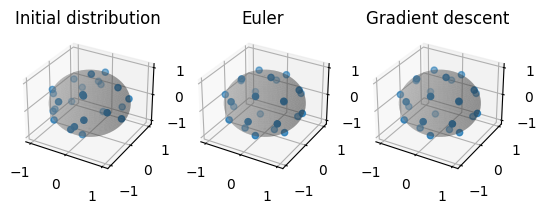

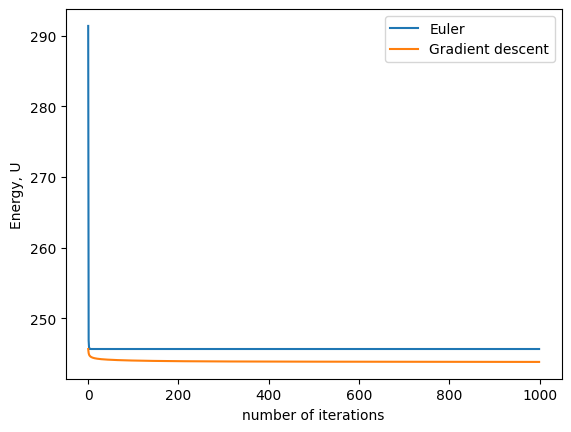

In [12]:
import time

N = 25 # particle number
initial_coordinate = random_initial(N)


fig = plt.figure()
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(x, y, z, color='gray', alpha=0.3)
ax2.plot_surface(x, y, z, color='gray', alpha=0.3)
ax3.plot_surface(x, y, z, color='gray', alpha=0.3)


ax1.scatter(initial_coordinate[:,0],initial_coordinate[:,1],initial_coordinate[:,2])
ax1.set_title('Initial distribution')

energies = []

#for euler:
start = time.time()
final_euler = euler(initial_coordinate,1000,0.1)
final_e = final_euler[0]
energies_e = final_euler[1]
ax2.scatter(final[:,0],final[:,1],final[:,2])
ax2.set_title('Euler')
end = time.time()
print('time for Euler',end-start)

start = time.time()
#for gradient descent:
final_gradient = gradient_descent(initial_coordinate,1000,0.1)
final_g = final_gradient[0]
energies_g = final_gradient[1]
ax3.scatter(final[:,0],final[:,1],final[:,2])
ax3.set_title('Gradient descent')
end = time.time()
print('time for Gradient descent',end-start)

plt.show()


plt.figure()
plt.plot(energies_e, label='Euler')
plt.plot(energies_g, label='Gradient descent')
plt.xlabel('number of iterations')
plt.ylabel('Energy, U')
plt.legend()
plt.show()

Gradient descent has lower potential than Euler. Euler actually runs very long while gradient descent runs very very fast (didn't time ) but both actually works! We can see it from the 3D plot and from the energy versus iteration plot.


#### We have showed in this activity how to solve the Thomson problem :)